# example of branch points
## for behavior figure

In [1]:
from pathlib import Path

import crowsetta
import evfuncs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.transforms as mtransforms
from matplotlib.patches import FancyBboxPatch
import numpy as np
import pandas as pd
import pyprojroot
import vak

import article
from article.plot.anchored_scale_bar import AnchoredScaleBar

In [2]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

In [3]:
# DATA_ROOT = pyprojroot.here() / 'data' / 'behavior-figure'
DATA_ROOT = Path('~/Documents/data/BFSongRepository/gr41rd51/').expanduser()
cbin = 'gr41rd51__3part_SYLc_th4191_belowhits_210612_1111.11046.cbin'
CBIN = DATA_ROOT / '062112' / cbin
NOTMAT = DATA_ROOT / '062112' / f'{cbin}.not.mat'

PREP_ROOT = pyprojroot.here() / 'data/BFSongRepository/learncurve/gr41rd51/spectrograms_generated_210521_212334'
NPZ = PREP_ROOT / f'{cbin}.spect.npz'

get amplitude, segments

In [4]:
rawsong, samp_freq = evfuncs.load_cbin(str(CBIN))
notmat_dict = evfuncs.load_notmat(str(NOTMAT))

smooth = evfuncs.smooth_data(rawsong, samp_freq)
threshold = notmat_dict['threshold']
min_syl_dur = notmat_dict['min_dur'] / 1000
min_silent_dur = notmat_dict['min_int'] / 1000
onsets, offsets = evfuncs.segment_song(smooth, samp_freq, threshold, min_syl_dur, min_silent_dur)

get spectrogram

In [5]:
spect_dict = vak.files.spect.load(NPZ)
s = spect_dict['s']
t = spect_dict['t']
f = spect_dict['f']

get annotation

In [6]:
scribe = crowsetta.Transcriber(format='notmat')
annot = scribe.from_file(str(NOTMAT))

In [8]:
labelmap = {
    label: ind for
    ind, label in enumerate(set(annot.seq.labels))
}

palette = article.plot.color_palette.color_palette_from_labelmap(labelmap, palette="colorblind")

get amplitude trace so we can put it on plot

log transform spectrogram and amplitude trace, and normalize amplitude trace too so it fits on annotation axes

In [9]:
s_log = np.log(s)
smooth_log_nrml = np.log10(smooth) / np.log10(smooth).max()
threshold_log_nrml = np.log10(threshold) / np.log10(smooth).max()
t_smooth = np.linspace(0, smooth_log_nrml.shape[0] * 1/samp_freq, smooth_log_nrml.shape[0])

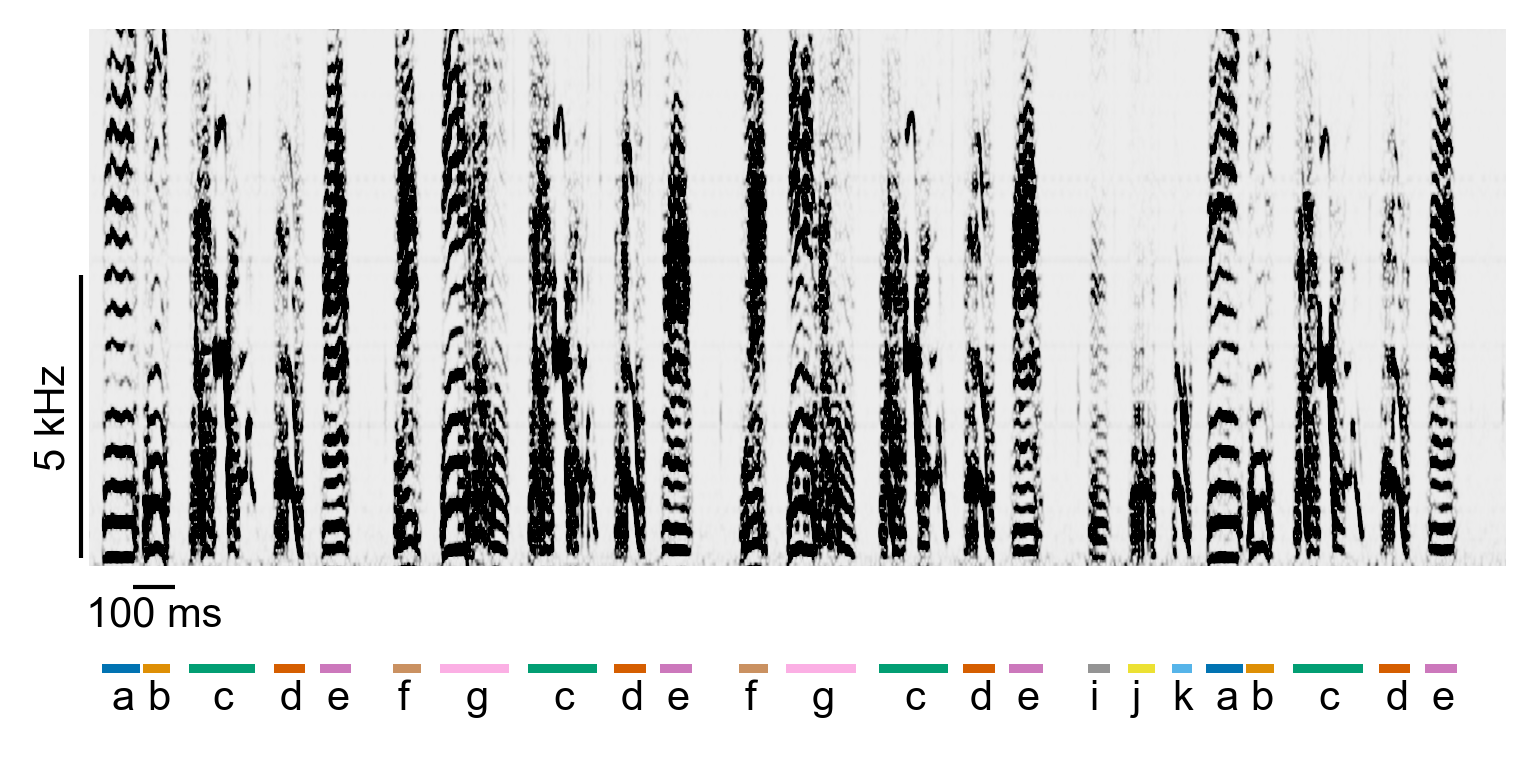

In [12]:
TMIN = 6.6
TMAX = 10
TLIM = (TMIN, TMAX)
TMIN_IND, TMAX_IND = [int(t * samp_freq) for t in (TMIN, TMAX)]

DPI = 300
FIGSIZE = (5, 2.5)

IMSHOW_KWARGS = {
    'vmin': -2,
    'vmax':12, 
    'cmap':'Greys'
}

FLIM = (500, 1e4)

fig = plt.figure(figsize=FIGSIZE, dpi=DPI, constrained_layout=True)
gs = fig.add_gridspec(2, 1, width_ratios=[1], height_ratios=[6, 1])
spect_ax = fig.add_subplot(gs[0, :])
annot_ax = fig.add_subplot(gs[1, :])

# plot spectrogram
vak.plot.spect(s, t, f, tlim=TLIM, flim=FLIM, ax=spect_ax, imshow_kwargs=IMSHOW_KWARGS)
x_scalebar = AnchoredScaleBar(transform=spect_ax.transData, sizex=0.1, labelx='100 ms', loc='lower right', 
                              pad=0.1,
                              barcolor='black',
                              bbox_to_anchor=(0.1, -0.14),
                              bbox_transform=spect_ax.transAxes)

spect_ax.add_artist(x_scalebar)

y_scalebar = AnchoredScaleBar(transform=spect_ax.transData, sizey=5000, labely='5 kHz', loc='lower right', 
                              pad=0.1,
                              barcolor='black',
                              bbox_to_anchor=(0.,0.),
                              bbox_transform=spect_ax.transAxes,
                              textprops={'rotation': 90})
spect_ax.add_artist(y_scalebar)

spect_ax.set_axis_off()

article.plot.annotation.annotation(annot, 
                                   palette,
                                   tlim=TLIM, 
                                   y_segments=0.9,
                                   seg_height=0.1,
                                   y_labels=0.5,
                                   ax=annot_ax,
                                   t_shift_label=0.0225, 
                                   text_kwargs={'fontname': 'Arial'})
            
handles, labels = annot_ax.get_legend_handles_labels()
handles += [annot_ax.texts[0]]
annot_ax.set_axis_off()

DST = pyprojroot.here() / 'doc' / 'article' / 'figures' / 'mainfig_bf_behavior'

for ext in ('svg', 'png'):
    fig.savefig(DST / f'branch-point-example.{ext}')